In [1]:
%load_ext autoreload
%autoreload 2

# `Logit` on Orders - A warm-up challenge (~1h)

## Select features

🎯 Let's figure out the impact of `wait_time` and `delay_vs_expected` on very `good/bad reviews`

👉 Using our `orders` training_set, we will run two `multivariate logistic regressions`:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

 

In [2]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

👉 Import your dataset:

In [3]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

👉 Select in a list which features you want to use:

⚠️ Make sure you are not creating data leakage (i.e. selecting features that are derived from the target)

💡 To figure out the impact of `wait_time` and `delay_vs_expected` we need to control for the impact of other features, include in your list all features that may be relevant

In [5]:
features = ['wait_time', 
            'delay_vs_expected', 
            'number_of_sellers', 
            'distance_seller_customer', 
            'price', 
            'freight_value']

🕵🏻 Check the `multi-colinearity` of your features, using the `VIF index`.

* It shouldn't be too high (< 10 preferably) to ensure that we can trust the partial regression coefficents and their associated `p-values` 
* Do not forget to standardize your data ! 
    * A `VIF Analysis` is made by regressing a feature vs. the other features...
    * So you want to `remove the effect of scale` so that your features have an equal importance before running any linear regression!
    
    
📚 <a href="https://www.statisticshowto.com/variance-inflation-factor/">Statistics How To - Variance Inflation Factor</a>

📚  <a href="https://online.stat.psu.edu/stat462/node/180/">PennState - Detecting Multicollinearity Using Variance Inflation Factors</a>

⚖️ Standardizing:

In [6]:
order_standardised = orders.copy()

for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    order_standardised[f] = orders[f].map(lambda x: (x - mu) / sigma)
    
order_standardised

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431192,15.544063,-0.161781,delivered,0,0,4,1,-0.112544,-0.513802,-0.652038,-1.042253
1,53cdb2fc8bc7dce0b6741e2150273451,0.134174,19.137766,-0.161781,delivered,0,0,4,1,-0.112544,-0.086640,0.000467,0.203930
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329907,26.639711,-0.161781,delivered,1,0,5,1,-0.112544,0.111748,-0.164053,-0.365480
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073540,26.188819,-0.161781,delivered,1,0,5,1,-0.112544,-0.441525,0.206815,2.123085
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019535,12.112049,-0.161781,delivered,1,0,5,1,-0.112544,-0.562388,-0.652038,-1.013580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95875,9c5dedf39a927c1b2549525ed64a053c,-0.454309,18.587442,-0.161781,delivered,1,0,5,1,-0.112544,-0.311513,-0.449408,-0.926554
95876,63943bddc261676b46f01ca7ac2f7bd8,1.023841,23.459051,-0.161781,delivered,0,0,4,1,-0.112544,0.183977,-0.123156,-0.088484
95877,83c1379a015df1e13d02aae0204711ab,1.305780,30.384225,-0.161781,delivered,1,0,5,1,-0.112544,0.333684,1.964490,0.818550
95878,11c177c8e97725db2631073c19f07b62,0.483664,37.105243,-0.161781,delivered,0,0,2,2,-0.112544,1.075186,2.715522,-0.304640


👉 Run your VIF Analysis to analyze the potential multicolinearities:

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['features'] = order_standardised[[
            'wait_time', 
            'delay_vs_expected', 
            'number_of_sellers', 
            'distance_seller_customer', 
            'price', 
            'freight_value']].columns



In [21]:
vif_data["VIF"] = [variance_inflation_factor(order_standardised[[
            'wait_time', 
            'delay_vs_expected', 
            'number_of_sellers', 
            'distance_seller_customer', 
            'price', 
            'freight_value']].values, i) for i in range(order_standardised[[
            'wait_time', 
            'delay_vs_expected', 
            'number_of_sellers', 
            'distance_seller_customer', 
            'price', 
            'freight_value']].shape[1])]

In [25]:
round(vif_data,2)

,features,VIF
0,wait_time,2.63
1,delay_vs_expected,2.21
2,number_of_sellers,1.02
3,distance_seller_customer,1.42
4,price,1.21
5,freight_value,1.36


## Logistic Regressions

👉 Fit two `Logistic Regression` models:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

`Logit 1️⃣`

In [26]:
logit_1 = smf.logit(formula='dim_is_one_star ~'+ ' + '.join(features), data=order_standardised).fit()
logit_1.summary()

Optimization terminated successfully.
         Current function value: 0.276600
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        dim_is_one_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95865
Method:                           MLE   Df Model:                            6
Date:                Thu, 29 Dec 2022   Pseudo R-squ.:                  0.1353
Time:                        16:31:10   Log-Likelihood:                -26518.
converged:                       True   LL-Null:                       -30669.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.4458      0.013   -191.850      0.000      -2.471      -2.421
wait_time                    0.6852      0.017     40.834      0.000       0.652       0.718
delay_vs_expected            0.2680      0.018     14.548      0.000       0.232       0.304
number_of_sellers            0.2299      0.008     30.546      0.000       0.215       0.245
distance_seller_customer    -0.2106      0.014    -15.335      0.000      -0.237      -0.184
price                        0.0417      0.011      3.877      0.000       0.021       0.063
freight_value                0.1059      0.011      9.533      0.000       0.084       0.128
============================================================================================
"""

`Logit 5️⃣`

In [28]:
logit_5 = smf.logit(formula='dim_is_five_star ~'+ ' + '.join(features), data=order_standardised).fit()
logit_5.summary()`

Optimization terminated successfully.
         Current function value: 0.638317
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       dim_is_five_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95865
Method:                           MLE   Df Model:                            6
Date:                Thu, 29 Dec 2022   Pseudo R-squ.:                 0.05586
Time:                        16:38:17   Log-Likelihood:                -61197.
converged:                       True   LL-Null:                       -64817.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3383      0.007     47.332      0.000       0.324       0.352
wait_time                   -0.5132      0.012    -43.949      0.000      -0.536      -0.490
delay_vs_expected           -0.4379      0.024    -18.626      0.000      -0.484      -0.392
number_of_sellers           -0.1719      0.008    -22.552      0.000      -0.187      -0.157
distance_seller_customer     0.1054      0.008     12.779      0.000       0.089       0.122
price                        0.0264      0.008      3.418      0.001       0.011       0.041
freight_value               -0.0612      0.009     -7.181      0.000      -0.078      -0.045
============================================================================================
"""

💡 It's time to analyse the results of these two logistic regressions:

- Interpret the partial coefficients in your own words.
- Check their statistical significances with `p-values`
- Do you notice any differences between `logit_one` and `logit_five` in terms of coefficient importances?

In [29]:
# Among the following sentences, store the ones that are true in the list below

a = "delay_vs_expected influences five_star ratings even more than one_star ratings"
b = "wait_time influences five_star ratings even more more than one_star"

your_answer = [a]

🧪 __Test your code__

In [30]:
from nbresult import ChallengeResult

result = ChallengeResult('logit',
    answers = your_answer
)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/bingobango/.pyenv/versions/tom/bin/python3
cachedir: .pytest_cache
rootdir: /Users/bingobango/code/lewagon/data-logit/tests
plugins: anyio-3.6.1, asyncio-0.19.0, typeguard-2.13.3
asyncio: mode=strict
collecting ... collected 1 item

test_logit.py::TestLogit::test_question PASSED                           [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/logit.pickle

git commit -m 'Completed logit step'

git push origin master



<details>
    <summary>- <i>Explanations and advanced concepts </i> -</summary>


> _All other thing being equal, the `delay factor` tends to increase the chances of getting stripped of the 5-star even more so than it affect the chances of 1-star reviews. Probably because 1-stars are really targeting bad products themselves, not bad deliveries_
    
❗️ However, to be totally rigorous, we have to be **more careful when comparing coefficients from two different models**, because **they might not be based on similar populations**!
    We have 2 sub-populations here: (people who gave 1-stars; and people who gave 5-stars) and they may exhibit intrinsically different behavior patterns. It may well be that "happy-people" (who tends to give 5-stars easily) are less sensitive as "grumpy-people" (who shoot 1-stars like Lucky-Luke), when it comes to "delay", or "price"...

</details>


## Logistic vs. Linear ?

👉 Compare the coefficients obtained from:
- A `Logistic Regression` to explain `dim_is_five_star`
- A `Linear Regression` to explain `review_score` 

Make sure to use the same set of features for both regressions.  

⚠️ Check that both sets of coefficients  tell  "the same story".

> YOUR ANSWER HERE

In [31]:
linear_model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=order_standardised).fit()

linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     2540.
Date:                Thu, 29 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:45:51   Log-Likelihood:            -1.5301e+05
No. Observations:               95872   AIC:                         3.060e+05
Df Residuals:                   95865   BIC:                         3.061e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.1555      0.004   1077.845      0.000       4.148       4.163
wait_time                   -0.4323      0.006    -69.109      0.000      -0.445      -0.420
delay_vs_expected           -0.0556      0.006     -9.704      0.000      -0.067      -0.044
number_of_sellers           -0.1608      0.004    -41.197      0.000      -0.168      -0.153
distance_seller_customer     0.1122      0.005     24.451      0.000       0.103       0.121
price                        0.0015      0.004      0.343      0.732      -0.007       0.010
freight_value               -0.0560      0.004    -12.471      0.000      -0.065      -0.047
==============================================================================
Omnibus:                    19281.824   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39131.253
Skew:                          -1.204   Prob(JB):                         0.00
Kurtosis:                       4.999   Cond. No.                         2.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

🏁 Congratulations! 

💾 Don't forget to commit and push your `logit.ipynb` notebook !

In [33]:
logit_5.params[1:]

wait_time                  -0.513188
delay_vs_expected          -0.437857
number_of_sellers          -0.171894
distance_seller_customer    0.105369
price                       0.026352
freight_value              -0.061209
dtype: float64

<AxesSubplot:title={'center':'Logit model'}>

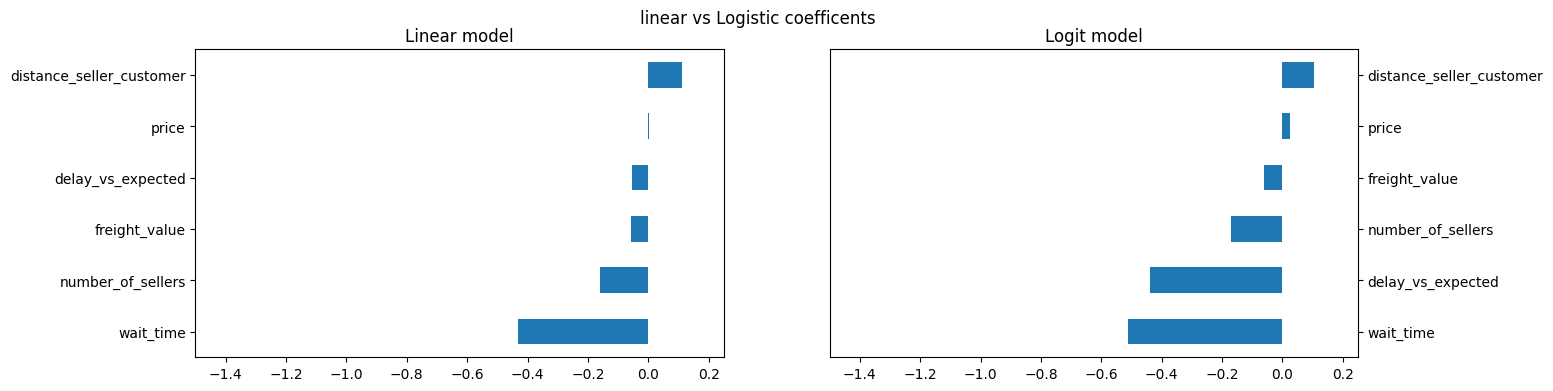

In [40]:
plt.figure(figsize=(15,4))
plt.suptitle("linear vs Logistic coefficents")
ax1 = plt.subplot(1,2,1)
ax1.set_xlim(-1.5, 0.25)
ax1.set_title("Linear model")
linear_model.params[1:].sort_values().plot(kind='barh', ax=ax1)

ax2 = plt.subplot(1,2,2)
ax2.set_title("Logit model")
ax2.yaxis.tick_right()
ax2.set_xlim(-1.5, 0.25)
logit_5.params[1:].sort_values().plot(kind='barh', ax=ax2)